**Ameya Dehade**

In [1]:
date_iterations = [
        
    # Entire Period
    ('2010-02-01', '2024-02-01'),
    
    # 2 year periods
    ('2022-02-01', '2024-02-01'),
    ('2020-02-01', '2022-02-01'),
    ('2018-02-01', '2020-02-01'),
    ('2016-02-01', '2018-02-01'),
    ('2014-02-01', '2016-02-01'),
    ('2012-02-01', '2014-02-01'),
    ('2010-02-01', '2012-02-01'),
    
    # 3 year periods
    ('2021-02-01', '2024-02-01'),
    ('2018-02-01', '2021-02-01'),
    ('2015-02-01', '2018-02-01'),
    ('2012-02-01', '2015-02-01'),
    ('2010-02-01', '2013-02-01'),
    
    # 4 year periods
    ('2020-02-01', '2024-02-01'),
    ('2016-02-01', '2020-02-01'),
    ('2012-02-01', '2016-02-01'),
    ('2010-02-01', '2014-02-01'),
    
    # 5 year periods
    ('2019-02-01', '2024-02-01'),
    ('2014-02-01', '2019-02-01'),
    ('2010-02-01', '2015-02-01'),
    
    # 6 year periods
    ('2018-02-01', '2024-02-01'),
    ('2012-02-01', '2018-02-01'),
    ('2010-02-01', '2016-02-01'),
    
    # 8 year periods
    ('2016-02-01', '2024-02-01'),
    ('2010-02-01', '2018-02-01'),
]

atr_period_iterations = [
    7,
    10,
    14,
    17,
    28,
    32, 
    35,
    42,
    49,
    56,
    63
]

X = [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8
]

Y = X

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr 
import numpy as np

df = pd.read_csv('IBOVDia_03-04-24.csv')
tickers = df['Code'].values
end = len(tickers) - 2
mySymbols = [s + '.SA' for s in tickers[:end]]

# Overall time period
START_DATE = '2010-02-01'
TRUNCATE_DATE = '2011-02-01'
END_DATE = '2024-02-01'

priceTablesByTicker = {}

priceTable = pd.read_csv('priceTable.csv', parse_dates=[0])
priceTable.set_index(priceTable.columns[0], inplace=True)

for ticker in mySymbols:
    currTable = pd.read_csv(ticker + '_price_table.csv', parse_dates=[0])
    currTable.set_index(currTable.columns[0], inplace=True)
    priceTablesByTicker[ticker] = currTable

In [3]:
def normalize(panel_data):
    return panel_data.sub(panel_data.mean(axis=1), axis=0).div(panel_data.std(axis=1),axis=0)

# This function takes a panel of positions and returns a time series of returns (in $).
def returns_from_positions(position_data, df_rtn, truncate_date):
    return (position_data * df_rtn).truncate(before=truncate_date).sum(axis=1)

# This function takes a time series of daily returns & returns an annualized Sharpe ratio.
def sharpe_ratio(daily_return_series):
    return round(daily_return_series.mean() / daily_return_series.std() * 252**0.5, 2)

def rank_bin(panel_data, alpha):
    if alpha <=0 or alpha>=0.5:
        raise ValueError("Alpha should be greater than 0- and less than 0.5")
    return panel_data.apply(pd.qcut, axis=1, args=([0, alpha, 1-alpha, 1.],), labels=[-1,0,1]).astype("float64")

def benchmark_strategies(priceTable, start_date, end_date):
    rtn = priceTable.loc[start_date:end_date].pct_change()*100
    truncate_date = pd.to_datetime(start_date) + pd.DateOffset(years=1)
    # mean reversion signal based on r(t-5) + ... + r(t-1)
    mr_sig_raw = -rtn.shift(1).rolling(5).sum().dropna(how='all')
    # momentum signal based on r(t-252) + ... + r(t-22)
    mom_sig_raw = rtn.shift(22).rolling(231).sum().dropna(how='all')
    # Go long $1 for the top 40%, short $1 for the bottom 40%, and flat for the middle 20%.
    mom_ranked_position = rank_bin(mom_sig_raw, 0.4)
    mr_ranked_position = rank_bin(mr_sig_raw, 0.4)

    mom_rtn = returns_from_positions(mom_ranked_position, rtn, truncate_date)
    mr_rtn  = returns_from_positions(mr_ranked_position,  rtn, truncate_date)
    
    mr_SR = sharpe_ratio(mr_rtn)
    mom_SR = sharpe_ratio(mom_rtn)

    both_rtn = 0.5*mom_rtn + 0.5*mr_rtn  # This is the return of a 50/50 portfolio of both strategies.
    both_SR = sharpe_ratio(both_rtn)
    
    return mom_rtn.cumsum()/mom_rtn.std()*0.15, mr_rtn.cumsum()/mr_rtn.std()*0.15, both_rtn.cumsum()/both_rtn.std()*0.15, mom_SR, mr_SR, both_SR

In [4]:
def calculate_atr(stock_data, period=14):
    high_low = stock_data['High'] - stock_data['Low']
    high_close = np.abs(stock_data['High'] - stock_data['Close'].shift())
    low_close = np.abs(stock_data['Low'] - stock_data['Close'].shift())
    tr = pd.DataFrame({'high_low': high_low, 'high_close': high_close, 'low_close': low_close}).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr

def turtle_atr(stock, atr_period=14, X=2, Y=2):
    # Calculate high, low, avg for original turtle strategy
    stock['high'] = stock['Close'].shift(1).rolling(window=5).max()  # 5 day high
    stock['low'] = stock['Close'].shift(1).rolling(window=5).min()   # 5 day low
    stock['avg'] = stock['Close'].shift(1).rolling(window=5).mean()  # 5 day mean

    # Calculate ATR
    stock['ATR'] = calculate_atr(stock, atr_period)

    #og turtle
    stock['long_entry'] = stock['Close'] > stock['high']
    stock['short_entry'] = stock['Close'] < stock['low']
    stock['long_exit'] = stock['Close'] < stock['avg']
    stock['short_exit'] = stock['Close'] > stock['avg']

    stock['positions_long'] = np.nan
    stock.loc[stock['long_entry'], 'positions_long'] = 1
    stock.loc[stock['long_exit'], 'positions_long'] = 0

    stock['positions_short'] = np.nan
    stock.loc[stock['short_entry'], 'positions_short'] = -1
    stock.loc[stock['short_exit'], 'positions_short'] = 0

    
    '''atr stuff (warning: may not work)'''
    #ATR stop loss and new position barrier logic
    stock['long_stop_loss'] = stock['Close'] - (X * stock['ATR'])
    stock['short_stop_loss'] = stock['Close'] + (X * stock['ATR'])
    
        # adj stop loss when a new high/low is reached
    stock['long_stop_loss'] = np.where((stock['Close'] > stock['high']) & (stock['positions_long'] == 1), 
                                       stock['Close'] - (X * stock['ATR']), 
                                       stock['long_stop_loss'])
                            
    stock['short_stop_loss'] = np.where((stock['Close'] < stock['low']) & (stock['positions_short'] == -1), 
                                        stock['Close'] + (X * stock['ATR']), 
                                        stock['short_stop_loss'])

    # sliding stop loss
    stock['long_stop_loss'] = stock['long_stop_loss'].ffill().where(stock['positions_long'] == 1)
    stock['short_stop_loss'] = stock['short_stop_loss'].ffill().where(stock['positions_short'] == -1)

    #exit positions based on stop loss
    stock.loc[stock['Close'] < stock['long_stop_loss'], 'positions_long'] = 0
    stock.loc[stock['Close'] > stock['short_stop_loss'], 'positions_short'] = 0

#     #exclusion zones
#     stock['long_exclusion_zone'] = stock['Close'] + (Y * stock['ATR'])
#     stock['short_exclusion_zone'] = stock['Close'] - (Y * stock['ATR'])
#     stock.loc[stock['Close'] < stock['long_exclusion_zone'], 'positions_long'] = 0
#     stock.loc[stock['Close'] > stock['short_exclusion_zone'], 'positions_short'] = 0
    
    
    # last stopped position
    stock['last_long_stop_out'] = ((stock['Close'] < stock['long_stop_loss']) & (stock['positions_long'].shift(1) == 1))
    stock['last_short_stop_out'] = ((stock['Close'] > stock['short_stop_loss']) & (stock['positions_short'].shift(1) == -1))

    # exclusion zones using 'shift(1)' to use the previous close to avoid looking ahead
    stock['long_exclusion_zone'] = stock['Close'].shift(1) + (Y * stock['ATR'].shift(1))
    stock['short_exclusion_zone'] = stock['Close'].shift(1) - (Y * stock['ATR'].shift(1))

    # apply exclusion zones to prevent trades
    stock.loc[stock['last_long_stop_out'], 'long_entry'] = False
    stock.loc[stock['Close'] < stock['long_exclusion_zone'], 'long_entry'] = False

    stock.loc[stock['last_short_stop_out'], 'short_entry'] = False
    stock.loc[stock['Close'] > stock['short_exclusion_zone'], 'short_entry'] = False

    
    #TODO: how to process entry/exit signals to affect the actual stock positions?
    
    stock.loc[(stock['positions_long'].shift(1) == 1), 'long_entry'] = False
    stock.loc[(stock['positions_short'].shift(1) == -1), 'short_entry'] = False
    stock['positions_long'] = stock['positions_long'].ffill().fillna(0)
    stock['positions_short'] = stock['positions_short'].ffill().fillna(0)

    # we can't enter a long position if we're in an exclusion zone or have a short position (vice versa for short)
    stock.loc[(stock['long_exclusion_zone'] > stock['Close']) | (stock['positions_short'] == -1), 'long_entry'] = False
    stock.loc[(stock['short_exclusion_zone'] < stock['Close']) | (stock['positions_long'] == 1), 'short_entry'] = False

    # update positions based on entry and exit signals
    stock.loc[stock['long_entry'], 'positions_long'] = 1
    stock.loc[stock['short_entry'], 'positions_short'] = -1
    stock.loc[stock['long_exit'], 'positions_long'] = 0
    stock.loc[stock['short_exit'], 'positions_short'] = 0

    # integrate exit conditions based on stop loss/ exclusion zones
    stock.loc[(stock['positions_long'] == 1) & (stock['Close'] < stock['long_stop_loss']), 'positions_long'] = 0
    stock.loc[(stock['positions_short'] == -1) & (stock['Close'] > stock['short_stop_loss']), 'positions_short'] = 0
    stock['positions'] = stock['positions_long'] + stock['positions_short']

    # no simultaneous long and short positions
    # stock['positions'] = stock['positions_long'].combine_first(stock['positions_short'])
    # Determine if a new position can be taken based on exclusion zones
    can_take_long = ~(stock['Close'] < stock['long_exclusion_zone']) & (stock['positions_short'] != -1)
    can_take_short = ~(stock['Close'] > stock['short_exclusion_zone']) & (stock['positions_long'] != 1)

    # update entry signals
    stock.loc[~can_take_long, 'long_entry'] = False
    stock.loc[~can_take_short, 'short_entry'] = False

    # signals update positions
    stock.loc[stock['long_entry'], 'positions_long'] = 1
    stock.loc[stock['short_entry'], 'positions_short'] = -1

    # position is 0 if there is an exit signal or a stop
    stock.loc[stock['long_exit'] | (stock['Close'] < stock['long_stop_loss']), 'positions_long'] = 0
    stock.loc[stock['short_exit'] | (stock['Close'] > stock['short_stop_loss']), 'positions_short'] = 0

    # ffill the positions to carry them through until the next change
    stock['positions_long'] = stock['positions_long'].ffill().fillna(0)
    stock['positions_short'] = stock['positions_short'].ffill().fillna(0)


    stock['log_returns'] = np.log(stock['Close'] / stock['Close'].shift())
    stock['strategy_returns'] = stock['positions'].shift(1) * stock['log_returns']

    # return cumulative returns
    return stock['strategy_returns'].cumsum()
    

    #returns
#     stock['positions'] = stock['positions_long'].fillna(0) + stock['positions_short'].fillna(0)
#     stock['log_returns'] = np.log(stock['Close'] / stock['Close'].shift())
#     stock['strategy_returns'] = stock['positions'].shift(1) * stock['log_returns']
    
#     return stock['strategy_returns'].cumsum()

def turtle_returns(priceTable, start_date, end_date, atr_period=14, X=2, Y=2):
    truncate_date = pd.to_datetime(start_date) + pd.DateOffset(years=1)
    daterange = pd.date_range(start=start_date, end=end_date, freq='D')
    totalret = pd.DataFrame(index=daterange) 
    for stock_ticker in mySymbols:
        totalret[stock_ticker] = turtle_atr(priceTablesByTicker[stock_ticker], atr_period, X, Y)  
    tt_sig_raw = totalret
    tt_sig_norm = normalize(tt_sig_raw)
    
    rtn = priceTable.loc[start_date:end_date].pct_change() * 100
    #tt_ranked_position = rank_bin(tt_sig_raw, 0.4)
    
    tt_rtn  = returns_from_positions(tt_sig_norm/(574-1),  rtn, truncate_date)
    
    tt_SR = sharpe_ratio(tt_rtn)

    # Originally return tt_rtn.cumsum()/tt_rtn.std()*0.15, tt_SR
    return tt_rtn.cumsum()/tt_rtn.std()*0.15, tt_SR

In [5]:
both_sharpe_map = {}
turtle_sharpe_to_parameter = {} # Map
winning_turtle_to_parameter = {} # Map from turtle sharpe to its parameters
turtle_wins = 0
total = 0

In [6]:
def printSharpesInDescending(parameter, turtle_sharpe_to_parameter):
    myKeys = list(turtle_sharpe_to_parameter.keys())  
    myKeys.sort(reverse=True)
    sorted_dict = {i: turtle_sharpe_to_parameter[i] for i in myKeys}
    # Sharpe and dates printed in descending order
    for i in myKeys:
        print("Turtle Sharpe Ratio is ", i, " for ", parameter, " ", turtle_sharpe_to_parameter[i])
    
    #if len(turtle_sharpe_to_parameter[0] == 1):
        
        
def printTurtleWins(parameter, winning_turtle_to_parameter):
    print("Turtle performed better ",  turtle_wins, " out of ",  total, " times")
    myKeys = list(winning_turtle_to_parameter.keys())
    myKeys.sort(reverse=True)
    sorted_dict = {i: winning_turtle_to_parameter[i] for i in myKeys}

    #Sharpe and dates printed in descending order
    for i in myKeys:
        print("Winning turtle Sharpe Ratio is ", i, " for ", parameter, ": ", winning_turtle_to_parameter[i])

def plotParameterToSharpe(x, y, data):
    # Extracting keys and values
    keys = list(data.keys())
    keys.sort()
    values = list(data.values())
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(keys, values, marker='o', linestyle='-')
    string = 'Mapping ' +  x  + ' to ' + y
    plt.title(string)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True)
    plt.show()

# Different Date Ranges

In [ ]:
data = []

for i, dates in enumerate(date_iterations):
    normalized_mom, normalized_mr, normalized_both, mom_sr, mr_sr, both_sr = benchmark_strategies(priceTable, *dates)
    both_sr = round(both_sr, 2)
    mom_sr = round(mom_sr, 2)
    mr_sr = round(mr_sr, 2)
    both_sharpe_map[both_sr] = (dates, normalized_mom, normalized_mr, normalized_both, mom_sr, mr_sr)
    normalized_turtle, turtle_sr = turtle_returns(priceTable, dates[0], dates[1])
    turtle_sr = round(turtle_sr, 2)
    turtle_sharpe_to_parameter[turtle_sr] = dates
    
    data.append({
        'Start Date': dates[0],
        'End Date': dates[1],
        'Combined Sharpe': both_sr,
        'Turtle Sharpe': turtle_sr
    })
    if i == 0:
        plt.figure()
        normalized_mom.plot() # Blue
        normalized_mr.plot() # Orange
        normalized_both.plot() # Green
        normalized_turtle.plot() # Red
    if turtle_sr > both_sr:
        turtle_wins += 1
        winning_turtle_to_parameter[turtle_sr] = dates
    total += 1
    if i == 0:
        year = dates[0][:4]
        year_num = int(year)
        year_num += 1
        trunc_date = str(year_num) + dates[0][4:]
        plt.xlim(trunc_date, dates[1])
        plt.show()
        print("Date Range:", trunc_date, " to ", dates[1])
        print("Sharpe for MoM, MR, and Both:", mom_sr, mr_sr, both_sr)
        print("Sharpe for Turtle:", turtle_sr)

df = pd.DataFrame(data)
#df.to_excel('output_file.xlsx', index=False)

In [ ]:
printSharpesInDescending("dates", turtle_sharpe_to_parameter)

In [ ]:
printTurtleWins("dates", winning_turtle_to_parameter)

# Different ATR Periods - DON'T RUN AGAIN

In [7]:
both_sharpe_map = {}
turtle_sharpe_to_parameter = {} # Map
parameter_to_turtle_sharpe = {}
parameter_to_graph_data = {}
winning_turtle_to_parameter = {} # Map from turtle sharpe to its parameters
turtle_wins = 0
total = 0

for i, atr in enumerate(atr_period_iterations):
    normalized_turtle, turtle_sr = turtle_returns(priceTable, *date_iterations[0], atr_period=atr)
    turtle_sr = round(turtle_sr, 2)
    turtle_sharpe_to_parameter[turtle_sr] = atr
    parameter_to_turtle_sharpe[atr] = turtle_sr
    #parameter_to_graph_data[atr] = normalized_turtle    

printSharpesInDescending("ATR Period", turtle_sharpe_to_parameter)    

Turtle Sharpe Ratio is  0.07  for  ATR Period   63


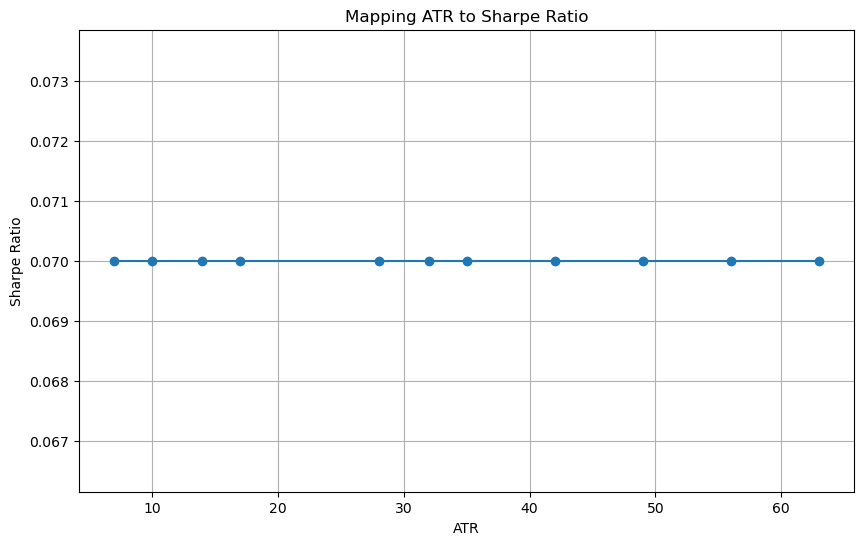

In [8]:
plotParameterToSharpe("ATR", "Sharpe Ratio", parameter_to_turtle_sharpe)

# Different widths of stop loss - TAKES A LONG TIME TO RUN

In [12]:
both_sharpe_map = {}
turtle_sharpe_to_parameter = {} # Map
parameter_to_turtle_sharpe = {}
parameter_to_graph_data = {}
winning_turtle_to_parameter = {} # Map from turtle sharpe to its parameters
turtle_wins = 0
total = 0

for i, y in enumerate(X):
    normalized_turtle, turtle_sr = turtle_returns(priceTable, *date_iterations[0], atr_period=10, X=x)
    turtle_sr = round(turtle_sr, 2)
    turtle_sharpe_to_parameter[turtle_sr] = atr
    parameter_to_turtle_sharpe[atr] = turtle_sr
    #parameter_to_graph_data[atr] = normalized_turtle    

printSharpesInDescending("ATR Period", turtle_sharpe_to_parameter)    

Turtle Sharpe Ratio is  0.07  for  ATR Period   63


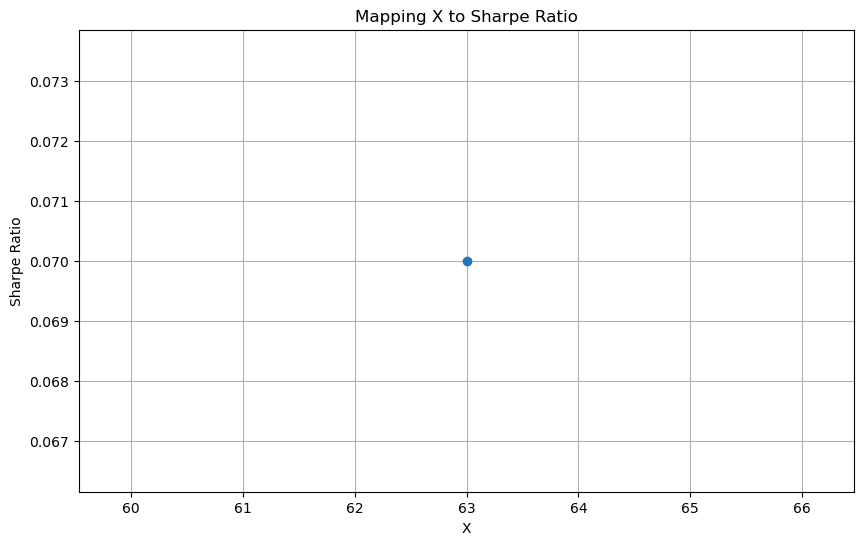

In [13]:
plotParameterToSharpe("X", "Sharpe Ratio", parameter_to_turtle_sharpe)

# Different widths of position barriers - TAKES A LONG TIME TO RUN

In [ ]:
both_sharpe_map = {}
turtle_sharpe_to_parameter = {} # Map
parameter_to_turtle_sharpe = {}
parameter_to_graph_data = {}
winning_turtle_to_parameter = {} # Map from turtle sharpe to its parameters
turtle_wins = 0
total = 0

for i, y in enumerate(Y):
    tot_turtle_sr = 0
    #for j, dates in enumerate(date_iterations):
    normalized_turtle, turtle_sr = turtle_returns(priceTable, *date_iterations[10], atr_period=10, Y=y)
    turtle_sr = round(turtle_sr, 2)
    print(y, turtle_sr)
    tot_turtle_sr += turtle_sr
    turtle_sr = tot_turtle_sr / (j + 1)
    turtle_sharpe_to_parameter[turtle_sr] = y
    parameter_to_turtle_sharpe[y] = turtle_sr
    
printSharpesInDescending("width of position barrier", turtle_sharpe_to_parameter)   